## Generator 可以使用 next 來進行循環中的一步
文字上有點難解釋，直接來看範例就能了解什麼是 Generator!

### 撰寫一個 Generator，一次吐出 list 中的一個值

In [0]:
def output_from_list_generator(your_list):
    for i in your_list:
        yield i 

In [0]:
my_list = [1, 2, 3, 4, 5]

In [0]:
gen = output_from_list_generator(my_list)

In [4]:
print(next(gen))

1


In [5]:
print(next(gen))

2


In [6]:
print(next(gen))

3


In [7]:
print(next(gen))

4


In [8]:
print(next(gen))

5


In [9]:
print(next(gen))

StopIteration: ignored

### 從上面的範例程式碼我們可以看到，當使用一次 next，generator 就會跑 for_loop 一次，因此得到 list 中的第一個值，當再使用一次後，for_loop 記得上次的循環，所以吐出第二個值。最後一次，因為 for loop 已經執行結束了，所以再使用 next 就會看到 StopIteration，無法在得到值

### 我們可以撰寫一個無限循環的 Generator，只要使用 While True 即可

In [0]:
def inf_loop_generator(your_list):
    while True:
        for i in your_list:
            yield i

In [0]:
gen = inf_loop_generator(my_list)

In [12]:
print(next(gen))

1


In [13]:
print(next(gen))

2


In [14]:
print(next(gen))

3


In [15]:
print(next(gen))

4


In [16]:
print(next(gen))

5


In [17]:
print(next(gen))

1


In [18]:
print(next(gen))

2


### 上面的程式碼因為我們使用了 While True，所以 for loop 不會結束，只要 call next 就一定會跑一次循環，並返回值

## 雖然 Cifar-10 的資料可以全部讀進記憶體，但讓我們試著用 Generator，批次的把 Cifar 10 的資料取出來，一次取 32 張出來！

In [0]:
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [20]:
from keras.datasets import cifar10

Using TensorFlow backend.


In [21]:
(x_train, x_test), (y_train, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 9s 0us/step


In [0]:
def cifar_generator(image_array, batch_size=32):
    while True:
        for indexs in range(0, len(image_array), batch_size):
            images = x_train[indexs: indexs+batch_size]
            labels = x_test[indexs: indexs+batch_size]
            yield images, labels

In [0]:
cifar_gen = cifar_generator(x_train)

In [0]:
images, labels = next(cifar_gen)

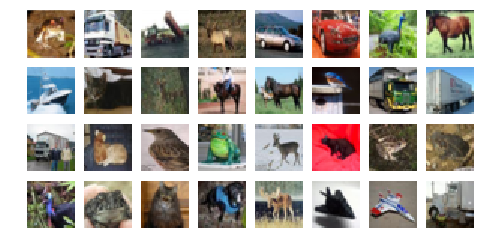

In [25]:
img_combine(images)

In [0]:
images, labels = next(cifar_gen)

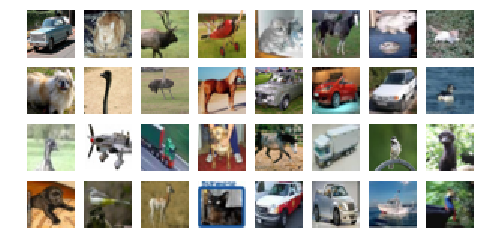

In [27]:
img_combine(images)

## 可以看到兩次的圖片並不一樣，這樣就可以開始訓練囉！

## 作業

請參考昨天的程式碼，將訓練資料讀取方式改寫成 Generator，並將原本的 model.fit 改為 model.fit_generator 來進行訓練。請參考 Keras [官方文件中 fit_generator 的說明](https://keras.io/models/sequential/)

In [0]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, RMSprop
import os

In [0]:
def preproc_x(x, flatten = True):
  x = x / 255.0
  if flatten:
    x = x.reshape((len(x),-1))
  return x

def preproc_y(y, num_classes = 10):
  if y.shape[-1] == 1:
    y = keras.utils.to_categorical(y,num_classes)
    
  return y

In [30]:
(train_x, train_y), (test_x, test_y) = cifar10.load_data()

train_x = preproc_x(train_x, False)
test_x = preproc_x(test_x, False)
train_y = preproc_y(train_y)
test_y = preproc_y(test_y)

print(f' train_x shape : {train_x.shape}')
print(f' train_y shape : {train_y.shape}')
print(f' test_x shape : {test_x.shape}')
print(f' test_y shape : {test_y.shape}')

 train_x shape : (50000, 32, 32, 3)
 train_y shape : (50000, 10)
 test_x shape : (10000, 32, 32, 3)
 test_y shape : (10000, 10)


In [0]:
def build_CNN(input_shape, output_units = 10):
  
  
  input_layer = keras.layers.Input(input_shape)
  
  x = Conv2D(filters = 32, kernel_size = (3,3), padding = 'same')(input_layer)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters = 32, kernel_size = (3,3), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.25)(x)
  
  x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.25)(x)
  
  x = Conv2D(filters = 128, kernel_size = (3,3), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters = 128, kernel_size = (3,3), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.25)(x)
  
  x = Flatten()(x)
  x = Dense(units = 512)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.25)(x)
  
  x = Dense(units = 256)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.25)(x)
  
  x = Dense(units = 128)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.25)(x)
  
  output_layer = Dense(units = output_units, activation = 'softmax')(x)
  
  model = keras.models.Model( inputs = [input_layer], outputs = [output_layer])
  return model


In [0]:
def cifar_gen(image_arr, batch_size = 128):
    while True:
        for idx in range(0,  len(image_arr), batch_size):
            images = train_x[idx : idx + batch_size]
            labels = train_y[idx : idx + batch_size]
            
            yield images, labels

In [37]:
data_gen = cifar_gen(train_x)

_x, _y = next(data_gen)
print(_x.shape)
print(_y.shape)

(128, 32, 32, 3)
(128, 10)


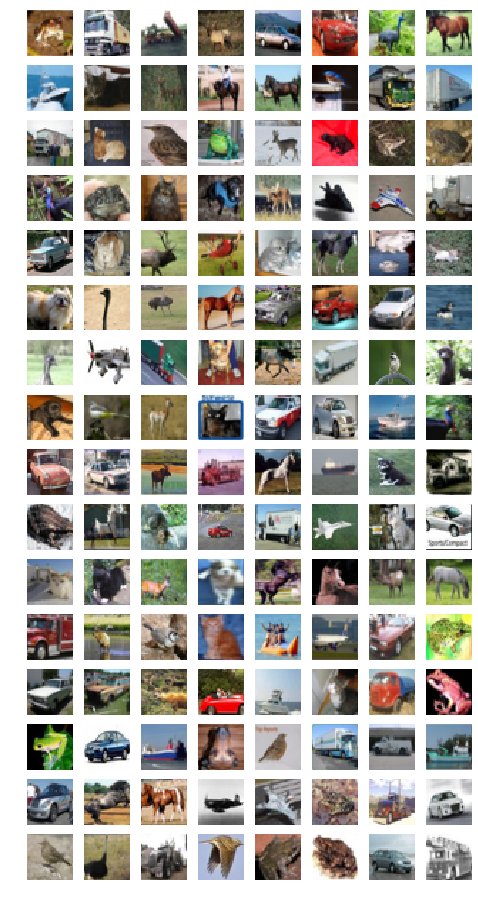

In [38]:
img_combine(_x)

In [42]:
cnn_model = build_CNN(train_x.shape[1:])
#sgd = keras.optimizers.SGD(lr = 0.001, momentum = 0.95, nesterov = True)
adam = keras.optimizers.Adam(lr = 0.001)
cnn_model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = adam)
cnn_model.summary()

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, min_lr = 1e-6)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_19 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_20 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_20 (Activation)   (None, 32, 32, 32)        0         
__________

In [0]:
batch_size = 128
epochs = 100

In [46]:
history = cnn_model.fit_generator(data_gen, steps_per_epoch = train_x.shape[0] // batch_size,
                                  epochs = epochs, validation_data = (test_x, test_y), callbacks = [reduce_lr] )

Epoch 1/100
390/390 [==============================] - 11s 28ms/step - loss: 0.2014 - acc: 0.9296 - val_loss: 0.5319 - val_acc: 0.8507
Epoch 2/100
390/390 [==============================] - 11s 28ms/step - loss: 0.1896 - acc: 0.9336 - val_loss: 0.5773 - val_acc: 0.8413
Epoch 3/100
390/390 [==============================] - 11s 28ms/step - loss: 0.1824 - acc: 0.9354 - val_loss: 0.5185 - val_acc: 0.8534
Epoch 4/100
390/390 [==============================] - 11s 28ms/step - loss: 0.1779 - acc: 0.9362 - val_loss: 0.5563 - val_acc: 0.8458
Epoch 5/100
390/390 [==============================] - 11s 27ms/step - loss: 0.1725 - acc: 0.9389 - val_loss: 0.5500 - val_acc: 0.8472
Epoch 6/100
390/390 [==============================] - 11s 27ms/step - loss: 0.1630 - acc: 0.9422 - val_loss: 0.5422 - val_acc: 0.8478
Epoch 7/100
390/390 [==============================] - 11s 27ms/step - loss: 0.1527 - acc: 0.9466 - val_loss: 0.5765 - val_acc: 0.8454
Epoch 8/100
390/390 [==============================] - 

10000/10000 [==============================] - 1s 147us/step
cnn loss : 0.6194430213361979
cnn acc : 0.8771


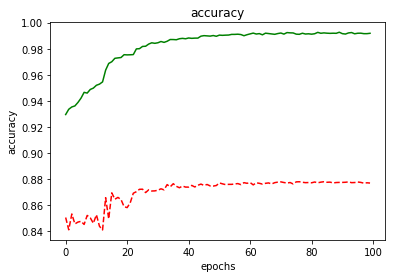

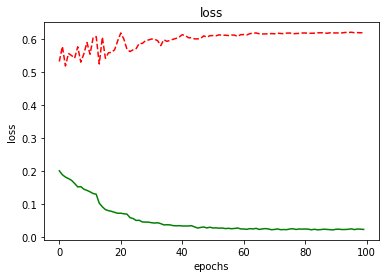

In [48]:
score = cnn_model.evaluate(test_x,test_y)
print(f'cnn loss : {score[0]}')
print(f'cnn acc : {score[1]}')

import matplotlib.pyplot as plt

plt.plot(history.history['acc'], '-', label = 'train_acc', color = 'g')
plt.plot(history.history['val_acc'],'--', label = 'valid_acc', color = 'r')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

plt.plot(history.history['loss'], '-', label = 'train_loss', color = 'g')
plt.plot(history.history['val_loss'],'--', label = 'valid_loss', color = 'r')
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()